# Data Analyze

## Setting

In [3]:
import pandas as pd
review = pd.read_csv("C:\\Users\\pps\\Desktop\\Restaurant_Review\\Review_Analyzer\\Data_Preprocessing\\S_hotel_buffet_review_IQR.csv", index_col= 0, encoding="utf-8")
review_strlist = review["Review_Text"].to_list()
review_string = ''.join(str(s) for s in review_strlist)

In [20]:
# 한글 글꼴 설정

font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

## 1) 형태소 분석

- `okt` 형태소 분석기 사용 후기  
    - 명사로 분리하는 기준이 명확하지 않아 명사가 아닌 것도 나오게 된다.
    - 동사/형용사는 같은 뜻을 가졌지만 다른 형태를 가진 중복 처리가 안된다.
- `kiwipiepy` 형태소 분석기 사용 후기
    - 명사로 분리하는 기준이 명확하다.
    - 동사/형용사는 중복처리를 하여 뜻이 하나인 형태만 나와 분류하기 편하다.

### 1-1 명사 분류 및 시각화

In [28]:
from konlpy.tag import Okt
from kiwipiepy import Kiwi

okt = Okt()
kiwi = Kiwi()

# okt 명사 형태소 분석기
def okt_noun_extractor(text):
    return okt.nouns(text)


# kiwipiepy 명사 형태소 분석기
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [5]:
review_okt_nouns = okt_noun_extractor(review_string)
review_kiwi_nouns = kiwi_noun_extractor(review_string)

In [7]:
# 워드 클라우드를 통해 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    return cloud_noun

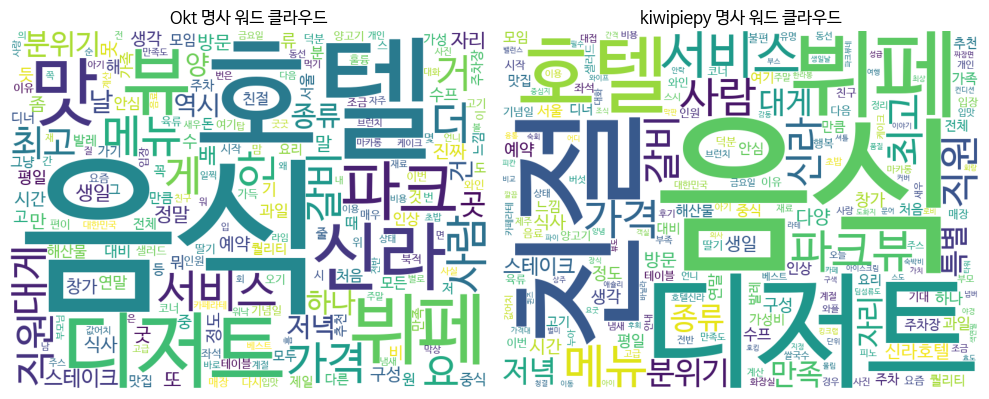

In [14]:
wc_okt = wordcloud_noun(review_okt_nouns)
wc_kiwi = wordcloud_noun(review_kiwi_nouns)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
plt.axis('off')
ax[0].imshow(wc_okt)
ax[0].set_title("Okt 명사 워드 클라우드")
ax[0].axis('off')
ax[1].imshow(wc_kiwi)
ax[1].set_title("kiwipiepy 명사 워드 클라우드")
ax[1].axis('off')
plt.tight_layout()
plt.show()

### 1-2 동사/형용사 분류 및 시각화

In [29]:
from konlpy.tag import Okt
from kiwipiepy import Kiwi

okt = Okt()
kiwi = Kiwi()

# 동사/형용사 okt 형태소 분석기
def okt_adj_verb_extractor(text):
    results = []
    result = okt.pos(text)
    
    for token, pos in result:
        if len(token) != 1 and pos.startswith('Adj'): #or pos.startswith('Verb'):
            results.append(token)
    return results

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [16]:
review_okt_adj_verb = okt_adj_verb_extractor(review_string)
review_kiwi_adj_verb = kiwi_verb_adj_extractor(review_string)

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    return cloud_verb_adj

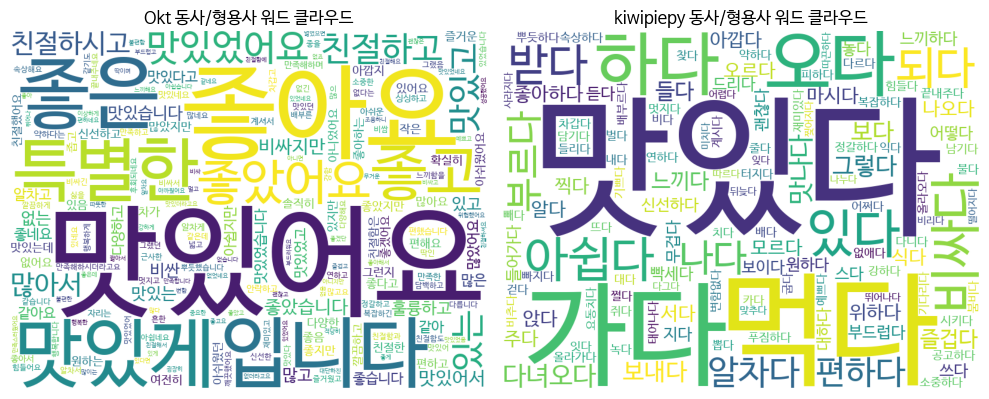

In [19]:
wc_okt_adj_verb = wordcloud_verb_adj(review_okt_adj_verb)
wc_kiwi_adj_verb = wordcloud_verb_adj(review_kiwi_adj_verb)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
plt.axis('off')
ax[0].imshow(wc_okt_adj_verb)
ax[0].set_title("Okt 동사/형용사 워드 클라우드")
ax[0].axis('off')

ax[1].imshow(wc_kiwi_adj_verb)
ax[1].set_title("kiwipiepy 동사/형용사 워드 클라우드")
ax[1].axis('off')

plt.tight_layout()
plt.show()

## 2) 카테고리별 긍/부정 분류

- 카테고리는 4개로 나누어 분류한다.
- 4개의 카테고리로 나누는 이유
    - 리뷰글에서 사람들에게 제일 많이 언급될 카테고리가 만족도, 맛, 서비스, 가격라고 생각했다.
    - 네이버 리뷰를 보면 키워드별 리뷰글을 볼 수 있게 남겨져 있는데 그 중 리뷰글이 많고 포괄적이게 쓰인 키워드들을 선택하였다.
- "맛" 카테고리는 음식별 긍/부정 평가를 분석하고 싶어 템플릿을 다르게 적용해보았다.
    - 템플릿이 명확하게 되어있지 않아 출력물에 음식이름뿐만 아니라 동사/형용사도 같이 나오게 되었다.
    - 템플릿을 고쳐가며 좀 더 발전시켜야 할 부분이다.

### 버전 1

In [60]:
import pandas as pd
import json
from typing import Dict, List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv
import re


load_dotenv()

review = pd.read_csv("C:\\Users\\pps\\Desktop\\Restaurant_Review\\Review_Analyzer\\Data_Preprocessing\\S_hotel_buffet_review_IQR.csv", index_col= 0, encoding="utf-8")
ten_review = review.copy()
ten_review = ten_review.head(10)
ten_review2 = ten_review.head(10)

In [52]:
from matplotlib import category


class ActionModel(BaseModel):
    positive: List[str] = Field(description="긍정을 나타내는 키워드")
    negative: List[str] = Field(description="부정을 나타내는 키워드")
    
class ReviewModel(BaseModel):
    category: str = Field(description="CATEGORY 문자열")
    action: ActionModel
    
parser = JsonOutputParser(pydantic_object = ReviewModel)
output_parser = StrOutputParser()

model = ChatOpenAI(model_name = "gpt-3.5-turbo")

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
- 당신은 SENTENCE에서 CATEGORY에 따라 긍/부정에 해당하는 키워드를 분류하는 역할입니다.
- 키워드는 긍/부정의 대상이며, 명사만 추출하세요.
- FORMAT에 맞춰 답변하세요.

# FORMAT: {format_instructions}
# CATEGORY: {category}
# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2).partial(format_instructions = parser.get_format_instructions(), category= "맛")
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(ten_review)):
    sentence = ten_review.Review_Text[i]
    result = combined.invoke({"sentence":sentence})
    
    parsed_result = {}
    for key, value in result.items():
        try:
            if key == "taste":
                parsed_result[key] = value
            else:
                parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}).get("action",{}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도"))
    columns["Taste Positive"].append(combined_result.get("positive","-"))
    columns["Taste Negative"].append(combined_result.get("negative","-"))
    columns["Service"].append(combined_result.get("서비스"))
    columns["Price"].append(combined_result.get("가격"))

In [53]:
ten_review["Satisfaction"] = columns["Satisfaction"]
ten_review["Taste Positive"] = columns["Taste Positive"]
ten_review["Taste Negative"] = columns["Taste Negative"]
ten_review["Service"] = columns["Service"]
ten_review["Price"] = columns["Price"]

In [54]:
ten_review

,UserID,Review_Text,Date,NumberOfVisit,Satisfaction,Taste Positive,Taste Negative,Service,Price
0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,"[음식, 호텔, 뷔페, 융통성]",[과일류],긍정,-
1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,"[종류, 맛]",-,긍정,긍정
2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,"[조식, 훌륭, 객실, 청결, 서비스, 친절, 편안]","[비싼, 돈]",긍정,긍정
3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,"[안락, 좋았어요, 맛있었어요, 달달, 새콤달콤, 서비스가 좋아서]","[차갑고, 짜고, 불어 있고, 너무 안 익은, 긴 줄]",긍정,-
4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,[음식],[],긍정,-
5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정,"[음식, 샐러드, 킹크랩, 재료, 고기, 디저트]",[],긍정,긍정
6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정,[뷔페],[],긍정,긍정
7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정,"[음식, 퀄리티, 짓수, 디저트, 남]",[],긍정,-
8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정,"[식사, 메뉴, 음식]",[],긍정,긍정
9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정,[기쁨],[],긍정,긍정


### 버전 2

- "맛" 카테고리에서 긍/부정에 대한 대상이 없다면 "음식 없음"을 출력하게 했다.
- "맛" 카테고리에서 맛에 대한 긍/부정 리뷰글이 없다면 "-"을 출력하게 했다.
- 이것도 위의 시도1과 마찬가지로 정확하고 완벽하게 분류되어 출력되지 않았다.

In [55]:
import pandas as pd
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv
import re


load_dotenv()

True

In [58]:
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
output_parser = StrOutputParser()

template1 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 만족도에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 만족도에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "만족도": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template2 = """\
# INSTRUCTION
1. You are tasked with classifying the sentiment as positive or negative based on reactions to taste in the SENTENCE.
2. If there is a reaction to taste, categorize the name of the food that caused the reaction as either "Taste Positive" or "Taste Negative".
3. If there is no reaction to taste, output "-" for both "Taste Positive" and "Taste Negative".
4. If there is a reaction to taste but the name of the food is not mentioned, output "음식 없음" for both categories.
5. Differentiate between reactions to the taste of food and evaluations of the restaurant.
6. Be careful not to mistake the name of a restaurant for the name of a food.
7. Output the result in dictionary format.

    "Taste Positive" : ["Food Name/음식 없음/-"]
    "Taste Negative" : ["Food Name/음식 없음/-"]

# SENTENCE: {sentence}
"""

template3 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 서비스에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 서비스에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "서비스": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

template4 = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 가격에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 가격에 대한 평가가 없는 경우 '-'을 표시하세요.
- 결과를 다음과 같은 딕셔너리 형식으로 출력하세요.

    "가격": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""

prompt1 = PromptTemplate.from_template(template1)
prompt2 = PromptTemplate.from_template(template2)
prompt3 = PromptTemplate.from_template(template3)
prompt4 = PromptTemplate.from_template(template4)

chain1 = prompt1 | model | output_parser
chain2 = prompt2 | model | output_parser
chain3 = prompt3 | model | output_parser
chain4 = prompt4 | model | output_parser

combined = RunnableParallel(
    satisfy = chain1,
    taste = chain2,
    service = chain3,
    price = chain4,
)


columns = {"Satisfaction":[], "Taste Positive":[], "Taste Negative": [], "Service":[], "Price":[]}
for i in range(len(ten_review)):
    result = combined.batch([{"sentence":ten_review.Review_Text[i]}])
    
    parsed_result = {}
    for key, value in result[0].items():
        try:
            parsed_result[key] = json.loads(value)
        except json.JSONDecodeError as e:
            continue
        
    combined_result = {
        **parsed_result.get("satisfy", {}),
        **parsed_result.get("taste", {}),
        **parsed_result.get("service", {}),
        **parsed_result.get("price", {}),
    }
    
    
    columns["Satisfaction"].append(combined_result.get("만족도", "-"))
    columns["Taste Positive"].append(combined_result.get("Taste Positive", "-"))
    columns["Taste Negative"].append(combined_result.get("Taste Negative", "-"))
    columns["Service"].append(combined_result.get("서비스","-"))
    columns["Price"].append(combined_result.get("가격", "-"))

In [61]:
ten_review2["Satisfaction"] = columns["Satisfaction"]
ten_review2["Taste Positive"] = columns["Taste Positive"]
ten_review2["Taste Negative"] = columns["Taste Negative"]
ten_review2["Service"] = columns["Service"]
ten_review2["Price"] = columns["Price"]

C:\Users\pps\AppData\Local\Temp\ipykernel_26176\3257201788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_review2["Satisfaction"] = columns["Satisfaction"]
C:\Users\pps\AppData\Local\Temp\ipykernel_26176\3257201788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_review2["Taste Positive"] = columns["Taste Positive"]
C:\Users\pps\AppData\Local\Temp\ipykernel_26176\3257201788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [62]:
ten_review2

,UserID,Review_Text,Date,NumberOfVisit,Satisfaction,Taste Positive,Taste Negative,Service,Price
0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,[-],[음식 없음],긍정,-
1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,[음식 없음],[음식 없음],긍정,긍정
2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,[음식 없음],[음식 없음],긍정,긍정
3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,"[대게, -, 양 갈비, 딸기, 한라봉]","[짜장면, 면, 문어 숙회, -, -]",긍정,긍정
4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,[-],[-],긍정,-
5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정,"[샐러드, 킹크랩, 스시, 고기, 디저트, 버]",[음식 없음],긍정,긍정
6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정,[-],[음식 없음],긍정,긍정
7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정,[음식 없음],[음식 없음],긍정,-
8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정,[음식 없음],[음식 없음],긍정,-
9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정,[음식 없음],[음식 없음],긍정,긍정


### 버전 3

- 카테고리별로 나누어 긍/부정을 확인하는 방법도 있지만 리뷰글 자체의 긍/부정도 확인할려고 한다.
- 이번엔 카테고리로 안나누고 긍/부정으로 분류하겠다.

In [9]:
import pandas as pd
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
review = pd.read_csv("C:\\Users\\pps\\Desktop\\Restaurant_Review\\Review_Analyzer\\Data_Preprocessing\\S_hotel_buffet_review_IQR.csv", index_col= 0, encoding="utf-8")

ten_review = review.copy().head(10)

In [13]:
template = """\
# INSTRUCTION
- 당신은 리뷰글 긍/부정 분류기입니다.
- 긍정과 부정이 SENTENCE에 같이 써져있으면 "-"로 분류하세요.
- SENTENCE를 [긍정, 부정, -]중 하나로 분류하세요.
- 다음과 같이 딕셔너리 형식으로 출력하세요.

    "긍/부정": "긍정/부정/-"
    
# SENTENCE: {sentence}
"""
model = ChatOpenAI(model_name = "gpt-3.5-turbo")
prompt = PromptTemplate.from_template(template)
chain = prompt | model

In [17]:
columns = {"긍/부정" : []}

# for i in range(len(ten_review)):
#     sentence = ten_review.Review_Text[i]
for i in range(len(review)):
    sentence = review.Review_Text[i]
    result = chain.invoke({"sentence":sentence})
    final = json.loads(result.content)
    columns["긍/부정"].append(final["긍/부정"])
    
review["긍/부정"] = columns["긍/부정"]

In [15]:
ten_review

,UserID,Review_Text,Date,NumberOfVisit,긍/부정
0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정
1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정
2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정
3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정
4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정
5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정
6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정
7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정
8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정
9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정


In [18]:
review.to_csv("./july_eighteenth_classify.csv", index=False, encoding="utf-8")

## 3) 긍/부정으로 분류된 데이터 시각화 및 분석

- 이 부분은 위에서 시도한 분류된 데이터가 아닌 원래 분류했던 처음 데이터를 기준으로 하겠다.

In [6]:
import pandas as pd

s_hotel_buffet_review_parsed = pd.read_csv("C:\\Users\\pps\\Desktop\\Restaurant_Review\\Review_Analyzer\\Data_Analyze\\S_hotel_buffet_review_parse.csv", index_col=0, encoding="utf-8")
review = s_hotel_buffet_review_parsed.copy()

In [7]:
# 한글 글꼴 설정
import matplotlib.pyplot as plt
import numpy as np
font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

### 3-1 각 카테고리별 긍/부정 개수 확인

In [3]:
def emotion_eval_counts(df, column_name):
    """긍정/부정/- 갯수 추출하는 함수"""
    return df[column_name].value_counts()

In [5]:
print(emotion_eval_counts(review, "만족도"))
print(emotion_eval_counts(review, "맛"))
print(emotion_eval_counts(review, "서비스"))
print(emotion_eval_counts(review, "가격"))

만족도
긍정    150
부정     11
-      10
Name: count, dtype: int64
맛
긍정    140
-      25
부정      6
Name: count, dtype: int64
서비스
-     93
긍정    67
부정    11
Name: count, dtype: int64
가격
-     100
부정     59
긍정     12
Name: count, dtype: int64


### 3-2 각 카테고리별 긍/부정 개수 막대 그래프 시각화

- 막대그래프를 통해 "만족도"와 "맛" 카테고리에 대한 긍/부정 평가가 "서비스", "가격"에 비해 월등히 많았다는 것을 알 수 있다.

In [68]:
def s_hotel_review_emote_bar(emote1,emote2,emote3,emote4):
    """카테고리 4개인 막대그래프 만드는 함수"""
    x = np.arange(4)
    
    satisf_Aemo = emote1["긍정"] + emote1["부정"]
    taste_Aemo = emote2["긍정"] + emote2["부정"]
    service_Aemo = emote3["긍정"] + emote3["부정"]
    price_Aemo = emote4["긍정"] + emote4["부정"]
    
    y_axis = [satisf_Aemo,taste_Aemo,service_Aemo,price_Aemo]
    x_axis = ["만족도","맛","서비스","가격"]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.title("카테고리별 긍/부정 갯수")
    plt.show()

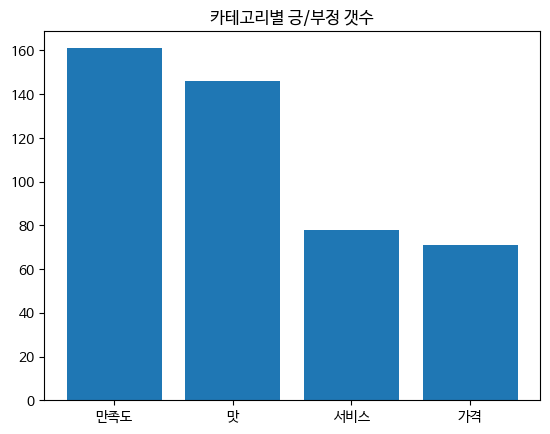

In [69]:
satisfy_emote = emotion_eval_counts(review, "만족도")
taste_emote = emotion_eval_counts(review, "맛")
service_emote = emotion_eval_counts(review, "서비스")
price_emote = emotion_eval_counts(review, "가격")

s_hotel_review_emote_bar(satisfy_emote,taste_emote,service_emote,price_emote)

### 3-3 각 카테고리별 긍/부정 비율 Pie 그래프 시각화

- Pie 그래프를 통해 "만족도", "맛", "서비스" 카테고리에선 긍정의 비율이 90%이상 많았다.
- 하지만, "가격" 카테고리에선 부정의 비율이 80& 이상 많았다.

In [70]:
# 평가 개수 구하기
satisfy_emo = emotion_eval_counts(review, "만족도")
taste_emo = emotion_eval_counts(review, "맛")
service_emo = emotion_eval_counts(review, "서비스")
price_emo = emotion_eval_counts(review, "가격")

# 긍정 + 부정 평가 개수 구하기
satisfy_total = satisfy_emo["긍정"] + satisfy_emo["부정"]
taste_total = taste_emo["긍정"] + taste_emo["부정"]
service_total = service_emo["긍정"] + service_emo["부정"]
price_total = price_emo["긍정"] + price_emo["부정"]

In [128]:
def percent_emotion(reviews, total_number):
    """백분율 구하는 함수"""
    return reviews / total_number * 100

In [72]:
# 각 카테고리별 긍/부정 비율 구하기
satisfy_positive = percent_emotion(satisfy_emo["긍정"], satisfy_total)
satisfy_negative = percent_emotion(satisfy_emo["부정"], satisfy_total)

taste_positive = percent_emotion(taste_emo["긍정"], taste_total)
taste_negative = percent_emotion(taste_emo["부정"], taste_total)

service_positive = percent_emotion(service_emo["긍정"], taste_total)
service_negative = percent_emotion(service_emo["부정"], taste_total)

price_positive = percent_emotion(price_emo["긍정"], price_total)
price_negative = percent_emotion(price_emo["부정"], price_total)

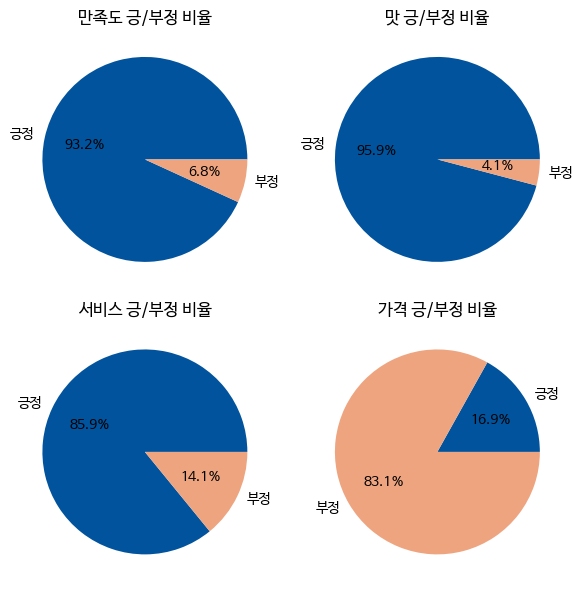

In [88]:
import matplotlib.pyplot as plt


ratio1 = [satisfy_positive, satisfy_negative]
ratio2 = [taste_positive, taste_negative]
ratio3 = [service_positive, service_negative]
ratio4 = [price_positive, price_negative]

labels = ["긍정", "부정"]
colors = ["#00539C", "#EEA47F"]

fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].set_title("만족도 긍/부정 비율")
ax[0,0].pie(ratio1, labels= labels, autopct='%.1f%%', colors = colors)

ax[0,1].set_title("맛 긍/부정 비율")
ax[0,1].pie(ratio2, labels= labels, autopct='%.1f%%', colors = colors)

ax[1,0].set_title("서비스 긍/부정 비율")
ax[1,0].pie(ratio3, labels= labels, autopct='%.1f%%', colors = colors)

ax[1,1].set_title("가격 긍/부정 비율")
ax[1,1].pie(ratio4, labels= labels, autopct='%.1f%%', colors = colors)

plt.tight_layout()
plt.show()

### 3-4 카테고리별 긍/부정 리뷰글 명사, 동사/형용사 추출 및 시각화

- 모든 카테고리의 리뷰글을 추출하지 않고 "만족도"와 "가격" 카테고리만 한다.
    - "만족도" 카테고리는 리뷰글 수가 제일 많았고 긍정 리뷰글 수도 제일 많았다.
    - "가격" 카테고리는 리뷰글 수가 적지만 부정 리뷰글 수가 많다.
- "만족도" 카테고리의 긍정 리뷰글과 "가격" 카테고리의 부정 리뷰글만 추출한 이유는 긍정 리뷰글중 제일 돋보이는 것과 부정 리뷰글중 제일 돋보이는 카테고리들이라 생각했다.
- 하지만, "만족도" 카테고리의 부정 리뷰글과 "가격" 카테고리의 긍정 리뷰글도 그 비율은 적지만 적은 만큼 이유가 확실할거라 생각하고 추출했다.

In [26]:
def positive_review_extractor(df, string_column, category_column):
    """카테고리에 긍정으로 표시된 리뷰글만 추출하는 함수

    Args:
        df (_type_): 데이터프레임
        string_column (_type_): 리뷰글항목
        category_column (_type_): 카테고리명
    """
    positive_reviews = {"긍정":[]}
    for i in range(len(df)):
        if df[category_column][i] == "긍정":
            positive_reviews["긍정"].append(df[string_column][i])
            
    return positive_reviews

def negative_review_extractor(df, string_column, category_column):
    """카테고리에 부정으로 표시된 리뷰글만 추출하는 함수

    Args:
        df (_type_): 데이터프레임
        string_column (_type_): 리뷰글항목
        category_column (_type_): 카테고리명
    """
    negative_reviews = {"부정":[]}
    # 가격항목에 부정이라 평가된 리뷰글만 추출
    for i in range(len(df)):
        if df[category_column][i] == "부정":
            negative_reviews["부정"].append(df[string_column][i])
    return negative_reviews

In [27]:
def positive_review_string_extractor(df):
    """딕셔너리로 받은 긍정 리뷰글 string으로 추출하는 함수"""
    for key, value in df.items():
        df[key] = ', '.join(value)
        
    positive_string = df.get("긍정")
    return positive_string

def negative_review_string_extractor(df):
    """딕셔너리로 받은 부정 리뷰글 string으로 추출하는 함수"""
    for key, value in df.items():
        df[key] = ', '.join(value)
        
    negative_string = df.get("부정")
    return negative_string

In [44]:
# "만족도", "가격" 카테고리 리뷰글 추출
satisfy_review = positive_review_extractor(review, "Review_Text","만족도")
satisfy_positive_string = positive_review_string_extractor(satisfy_review)
kiwi_satisfy_positive_noun = kiwi_noun_extractor(satisfy_positive_string)
kiwi_satisfy_positive_verb_adj = kiwi_verb_adj_extractor(satisfy_positive_string)

satisfy_negative_review = negative_review_extractor(review, "Review_Text", "만족도")
satisfy_negative_string = negative_review_string_extractor(satisfy_negative_review)
kiwi_satisfy_negative_noun = kiwi_noun_extractor(satisfy_negative_string)
kiwi_satisfy_negative_verb_adj = kiwi_verb_adj_extractor(satisfy_negative_string)

price_reviews = negative_review_extractor(review, "Review_Text","가격")
price_negative_string = negative_review_string_extractor(price_reviews)
kiwi_price_negative_noun = kiwi_noun_extractor(price_negative_string)
kiwi_price_negative_verb_adj = kiwi_verb_adj_extractor(price_negative_string)

price_positive_review = positive_review_extractor(review, "Review_Text", "가격")
price_positive_string = positive_review_string_extractor(price_positive_review)
kiwi_price_positive_noun = kiwi_noun_extractor(price_positive_string)
kiwi_price_positive_verb_adj = kiwi_verb_adj_extractor(price_positive_string)

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    """명사만 워드클라우드로 나타내는 함수"""
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    return cloud_noun

def wordcloud_verb_adj(verb_adj_text):
    """동사/형용사 워드 클라우드로 나타내는 함수"""
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    return cloud_verb_adj

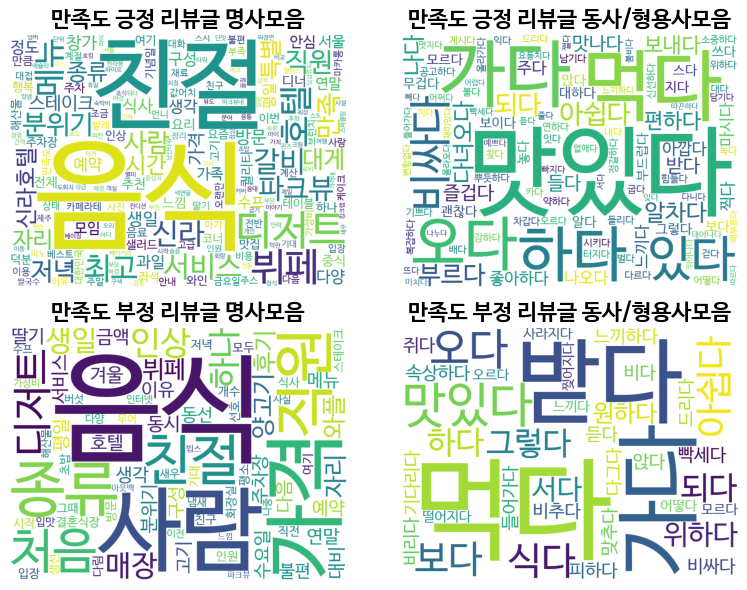

In [106]:
# 만족도 카테고리 명사, 동사/형용사 시각화
wc_satisfy_noun = wordcloud_noun(kiwi_satisfy_positive_noun)
wc_satisfy_verb_adj = wordcloud_verb_adj(kiwi_satisfy_positive_verb_adj)
wc_negative_satisfy_noun = wordcloud_noun(kiwi_satisfy_negative_noun)
wc_negative_satisfy_verb_adj = wordcloud_verb_adj(kiwi_satisfy_negative_verb_adj)

fig, ax = plt.subplots(2,2, figsize=(8, 6))
title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
plt.axis('off')
ax[0,0].imshow(wc_satisfy_noun)
ax[0,0].set_title("만족도 긍정 리뷰글 명사모음", title_font)
ax[0,0].axis('off')

ax[0,1].imshow(wc_satisfy_verb_adj)
ax[0,1].set_title("만족도 긍정 리뷰글 동사/형용사모음", title_font)
ax[0,1].axis('off')

ax[1,0].imshow(wc_negative_satisfy_noun)
ax[1,0].set_title("만족도 부정 리뷰글 명사모음", title_font)
ax[1,0].axis('off')

ax[1,1].imshow(wc_negative_satisfy_verb_adj)
ax[1,1].set_title("만족도 부정 리뷰글 동사/형용사모음", title_font)
ax[1,1].axis('off')
plt.tight_layout()
plt.show()

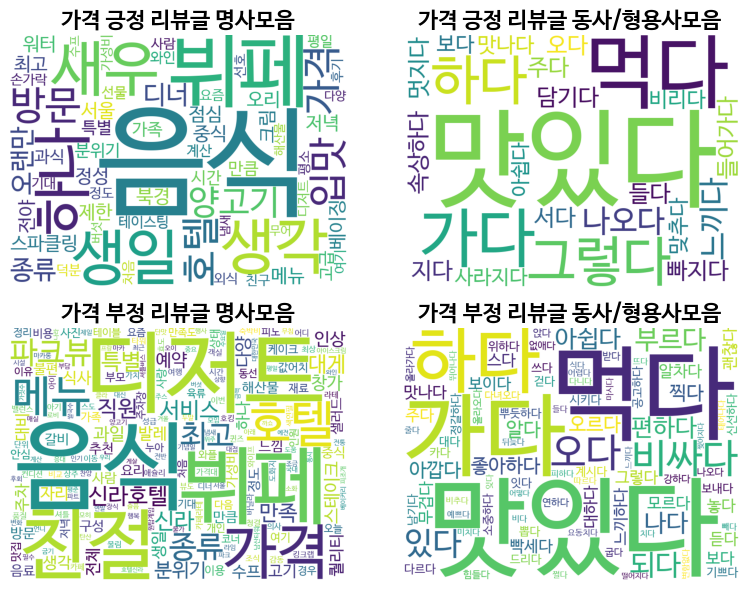

In [109]:
# 가격 카테고리 명사, 동사/형용사 시각화
wc_price_noun = wordcloud_noun(kiwi_price_negative_noun)
wc_price_verb_adj = wordcloud_verb_adj(kiwi_price_negative_verb_adj)
wc_price_positive_noun = wordcloud_noun(kiwi_price_positive_noun)
wc_price_positive_verb_adj = wordcloud_verb_adj(kiwi_price_positive_verb_adj)

fig, ax = plt.subplots(2,2, figsize=(8, 6))
title_font = {
        'fontsize':16,
        'fontweight': 'bold'
    }
plt.axis('off')
ax[0,0].imshow(wc_price_positive_noun)
ax[0,0].set_title("가격 긍정 리뷰글 명사모음", title_font)
ax[0,0].axis('off')

ax[0,1].imshow(wc_price_positive_verb_adj)
ax[0,1].set_title("가격 긍정 리뷰글 동사/형용사모음", title_font)
ax[0,1].axis('off')

ax[1,0].imshow(wc_price_noun)
ax[1,0].set_title("가격 부정 리뷰글 명사모음", title_font)
ax[1,0].axis('off')

ax[1,1].imshow(wc_price_verb_adj)
ax[1,1].set_title("가격 부정 리뷰글 동사/형용사모음", title_font)
ax[1,1].axis('off')
plt.tight_layout()
plt.show()

### 3-5 빈도 높은 명사 3개 긍정/부정 분류

- "만족도" 카테고리의 긍정/부정 리뷰글 빈출 많은 명사 3개를 위의 워드 클라우드를 통해 뽑는다.
- 최대한 다른 명사들로 하고 싶어 의미가 비슷한 명사는 하나를 임의로 지정하겠다.
- "가격" 카테고리의 긍정/부정 리뷰글 빈출 많은 명사 3개를 위의 워드 클라우드를 통해 뽑는다.
- '뷔페', '호텔' 등의 식당 이름 혹은 식당을 나타내는 단어는 빼도록 하겠다.

- 만족도 긍정 리뷰글 빈도 높은 명사 3개
    1. 음식  
    2. 친절  
    3. 디저트  
    
- 만족도 부정 리뷰글 빈도 높은 명사 3개
    1. 음식  
    2. 사람  
    3. 가격  

In [57]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_satisfy_positive_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"디저트": [], "음식":[], "친절":[]}
    for sentence in df["긍정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["디저트"].append(test_result["디저트"])
        temp["음식"].append(test_result["음식"])
        temp["친절"].append(test_result["친절"])

    df["긍정_디저트"] = temp["디저트"]
    df["긍정_음식"] = temp["음식"]
    df["긍정_친절"] = temp["친절"]

    
    df.to_csv("./july_eighteenth_satisfy_positive_noun_classify.csv", index = False)
    return df

def save_satisfy_negative_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"음식": [], "사람":[], "가격":[]}
    for sentence in df["부정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["음식"].append(test_result["음식"])
        temp["사람"].append(test_result["사람"])
        temp["가격"].append(test_result["가격"])

    df["부정_음식"] = temp["음식"]
    df["부정_사람"] = temp["사람"]
    df["부정_가격"] = temp["가격"]

    
    df.to_csv("./july_eighteenth_satisfy_negative_noun_classify.csv", index = False)
    return df

load_dotenv()

positive_template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '디저트', '음식', '친절'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "디저트": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "친절": "긍정/부정/-",

# SENTENCE:{sentence}
"""
negative_template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '음식', '사람', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "음식": "긍정/부정/-",
    "사람": "긍정/부정/-",
    "가격": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [54]:
# chain = MyChain(template=template)
import pandas as pd

satisfy_review_positive = positive_review_extractor(review, "Review_Text","만족도")
satisfy_review_negative = negative_review_extractor(review, "Review_Text","만족도")
df_satisfy_positive = pd.DataFrame(satisfy_review_positive)
df_satisfy_negative = pd.DataFrame(satisfy_review_negative)

In [58]:
positive_satisfy_chain = MyChain(positive_template)
satisfy_positive_parse_review = save_satisfy_positive_reviews(df_satisfy_positive, positive_satisfy_chain)

negative_satisfy_chain = MyChain(negative_template)
satisfy_negative_parse_review = save_satisfy_negative_reviews(df_satisfy_negative,negative_satisfy_chain)

In [62]:
satisfy_positive_parse_review.head()

,긍정,긍정_디저트,긍정_음식,긍정_친절
0,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,-,긍정,긍정
1,종류도 알차게 많고 다 맛있어요,긍정,긍정,-
2,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,-,긍정,긍정
3,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,긍정,부정,긍정
4,항상 친절하시고 음식도 맛있네요,-,긍정,긍정


In [63]:
satisfy_negative_parse_review.head()

,부정,부정_음식,부정_사람,부정_가격
0,생각보다 음식이 종류가 적어서 속상해요,부정,-,-
1,12월엔 꼭 가야 할 일 아니면 비추 일단 연말이라는 이유로 금액이 비싸 짐과 동시...,긍정,-,부정
2,딸기 원 없이 먹고 왔어요 많이 먹자 했는데 막상 또 많이는 못 먹게 되더라고요 디...,부정,-,부정
3,분위기는 좋지만 가격 대비 음식 구성이 그리 대단하진 않아 요 몇 번째 갔는데 좀 ...,부정,-,부정
4,직원들은 친절 하나 매장도 좁고 메뉴도 적은 듯 동선도 불편함,부정,긍정,-


- 가격 긍정 리뷰글 빈도 높은 명사 3개
    1. 가격  
    2. 음식  
    3. 생일  

- 가격 부정 리뷰글 빈도 높은 명사 3개
    1. 디저트
    2. 가격
    3. 친절

In [83]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_price_positive_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"가격": [], "음식":[], "생일":[]}
    for sentence in df["긍정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["가격"].append(test_result.get("가격"))
        temp["음식"].append(test_result.get("음식"))
        temp["생일"].append(test_result.get("생일"))

    df["긍정_가격"] = temp["가격"]
    df["긍정_음식"] = temp["음식"]
    df["긍정_생일"] = temp["생일"]

    
    df.to_csv("./july_eighteenth_price_positive_noun_classify.csv", index = False)
    return df

def save_price_negative_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"디저트": [], "가격":[], "친절":[]}
    for sentence in df["부정"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["디저트"].append(test_result.get("디저트"))
        temp["가격"].append(test_result.get("가격"))
        temp["친절"].append(test_result.get("친절"))

    df["부정_디저트"] = temp["디저트"]
    df["부정_가격"] = temp["가격"]
    df["부정_친절"] = temp["친절"]

    
    df.to_csv("./july_eighteenth_price_negative_noun_classify.csv", index = False)
    return df

load_dotenv()

template_positive = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '가격', '음식', '생일'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "가격": "긍정/부정/-",
    "음식": "긍정/부정/-",
    "생일": "긍정/부정/-",

# SENTENCE:{sentence}
"""

template_negative = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '디저트', '가격', '친절'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "디저트": "긍정/부정/-",
    "가격": "긍정/부정/-",
    "친절": "긍정/부정/-",

# SENTENCE:{sentence}
"""


In [84]:
price_review_positive = positive_review_extractor(review, "Review_Text","가격")
price_review_negative = negative_review_extractor(review, "Review_Text","가격")
df_price_positive = pd.DataFrame(price_review_positive)
df_price_negative = pd.DataFrame(price_review_negative)

In [85]:
positive_price_chain = MyChain(template_positive)
price_positive_parse_review = save_price_positive_reviews(df_price_positive, positive_price_chain)

negative_price_chain = MyChain(template_negative)
price_negative_parse_review = save_price_negative_reviews(df_price_negative,negative_price_chain)

In [86]:
price_positive_parse_review.head()

,긍정,긍정_가격,긍정_음식,긍정_생일
0,생각보다 음식이 종류가 적어서 속상해요,-,부정,-
1,오랜만에 디너 왔어요 스파클링 워터 무제한이었고요 전엔 안 그랬던 거 같은데 북경 ...,-,긍정,부정
2,굿,부정,긍정,-
3,서울 3대 뷔페 어서 점심 먹었는데 너무 맛있어요 중식 베이징 덕 크림새우 등 최고,부정,긍정,-
4,뷰도 멋지고 메뉴들도 하나 하나 정성이 가득 담겨 있는 듯 담백하고 맛있었어요,-,긍정,긍정


In [87]:
price_negative_parse_review.head()

,부정,부정_디저트,부정_가격,부정_친절
0,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,-,부정,긍정
1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,긍정,긍정,-
2,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,긍정,긍정,긍정
3,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,긍정,긍정,-
4,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,긍정,긍정,긍정


### 3-6 빈도 높은 명사들의 총 긍/부정 개수

- 빈도 높은 명사들의 총 긍/부정 개수를 구하여 리뷰글에서 언급되는 양을 확인해본다.

In [92]:
print(emotion_eval_counts(satisfy_positive_parse_review, "긍정_디저트"))
print(emotion_eval_counts(satisfy_positive_parse_review, "긍정_음식"))
print(emotion_eval_counts(satisfy_positive_parse_review, "긍정_친절"))

print(emotion_eval_counts(satisfy_negative_parse_review, "부정_음식"))
print(emotion_eval_counts(satisfy_negative_parse_review, "부정_사람"))
print(emotion_eval_counts(satisfy_negative_parse_review, "부정_가격"))

긍정_디저트
-     87
긍정    56
부정     7
Name: count, dtype: int64
긍정_음식
긍정    132
-      10
부정      8
Name: count, dtype: int64
긍정_친절
긍정    92
-     52
부정     6
Name: count, dtype: int64
부정_음식
부정    7
긍정    3
-     1
Name: count, dtype: int64
부정_사람
-     5
부정    4
긍정    2
Name: count, dtype: int64
부정_가격
-     7
부정    4
Name: count, dtype: int64


In [133]:
# 평가 개수 구하기
satisfy_pos_dessert_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_디저트")
satisfy_pos_food_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_음식")
satisfy_pos_kindness_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_친절")

satisfy_neg_food_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_음식")
satisfy_neg_customer_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_사람")
satisfy_neg_price_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_가격")


# 긍정 + 부정 평가 개수 구하기
satisfy_pos_dessert_total = satisfy_pos_dessert_emo["긍정"] + satisfy_pos_dessert_emo["부정"]
satisfy_pos_food_total = satisfy_pos_food_emo["긍정"] + satisfy_pos_food_emo["부정"]
satisfy_pos_kindness_total = satisfy_pos_kindness_emo["긍정"] + satisfy_pos_kindness_emo["부정"]

satisfy_neg_food_total = satisfy_neg_food_emo["긍정"] + satisfy_neg_food_emo["부정"]
satisfy_neg_customer_total = satisfy_neg_customer_emo["긍정"] + satisfy_neg_customer_emo["부정"]
satisfy_neg_price_emo_total = satisfy_neg_price_emo["부정"]

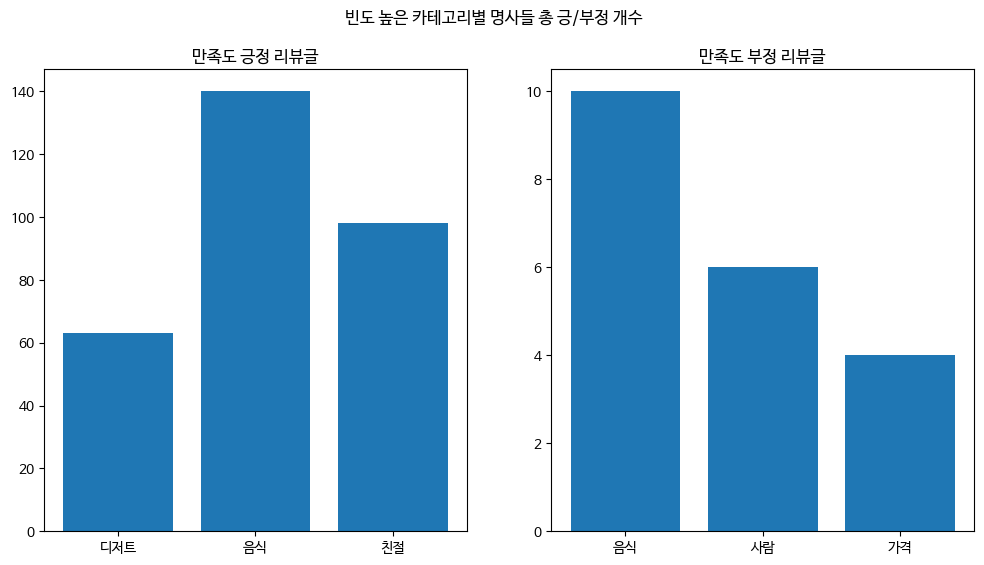

In [127]:
x_positive = np.arange(3)
satisfy_pos_dessert_emo = satisfy_pos_dessert_total
satisfy_pos_food_emo = satisfy_pos_food_total
satisfy_pos_kindness_emo = satisfy_pos_kindness_total

x_negative = np.arange(3)
satisfy_neg_food_emo = satisfy_neg_food_total
satisfy_neg_customer_emo = satisfy_neg_customer_total
satisfy_neg_price_emo = satisfy_neg_price_emo_total

fig, ax = plt.subplots(1,2, figsize=(12, 6))

y_s_pos_axis = [satisfy_pos_dessert_emo,satisfy_pos_food_emo,satisfy_pos_kindness_emo]
x_s_pos_axis = ["디저트","음식","친절"]
ax[0].bar(x_positive,y_s_pos_axis)
ax[0].set_xticks(x_positive)
ax[0].set_xticklabels(x_s_pos_axis)
ax[0].set_title("만족도 긍정 리뷰글")


y_s_neg_axis = [satisfy_neg_food_emo,satisfy_neg_customer_emo,satisfy_neg_price_emo]
x_s_neg_axis = ["음식","사람","가격"]
ax[1].bar(x_negative,y_s_neg_axis)
ax[1].set_xticks(x_negative)
ax[1].set_xticklabels(x_s_neg_axis)
ax[1].set_title("만족도 부정 리뷰글")

plt.suptitle("빈도 높은 카테고리별 명사들 총 긍/부정 개수")
plt.show()

In [93]:
print(emotion_eval_counts(price_positive_parse_review, "긍정_가격"))
print(emotion_eval_counts(price_positive_parse_review, "긍정_음식"))
print(emotion_eval_counts(price_positive_parse_review, "긍정_생일"))

print(emotion_eval_counts(price_negative_parse_review, "부정_디저트"))
print(emotion_eval_counts(price_negative_parse_review, "부정_가격"))
print(emotion_eval_counts(price_negative_parse_review, "부정_친절"))

긍정_가격
-     6
부정    3
긍정    3
Name: count, dtype: int64
긍정_음식
긍정    10
부정     2
Name: count, dtype: int64
긍정_생일
-     7
긍정    4
부정    1
Name: count, dtype: int64
부정_디저트
긍정    32
-     15
부정    10
Name: count, dtype: int64
부정_가격
부정    32
긍정    22
-      3
Name: count, dtype: int64
부정_친절
긍정    34
-     21
부정     2
Name: count, dtype: int64


In [167]:
# 평가 개수 구하기
price_pos_price_emo = emotion_eval_counts(price_positive_parse_review, "긍정_가격")
price_pos_food_emo = emotion_eval_counts(price_positive_parse_review, "긍정_음식")
price_pos_birthday_emo = emotion_eval_counts(price_positive_parse_review, "긍정_생일")

price_neg_dessert_emo = emotion_eval_counts(price_negative_parse_review, "부정_디저트")
price_neg_price_emo = emotion_eval_counts(price_negative_parse_review, "부정_가격")
price_neg_kindness_emo = emotion_eval_counts(price_negative_parse_review, "부정_친절")


# 긍정 + 부정 평가 개수 구하기
price_pos_price_total = price_pos_price_emo["긍정"] + price_pos_price_emo["부정"]
price_pos_food_total = price_pos_food_emo["긍정"] + price_pos_food_emo["부정"]
price_pos_birthday_total = price_pos_birthday_emo["긍정"] + price_pos_birthday_emo["부정"]

price_neg_dessert_total = price_neg_dessert_emo["긍정"] + price_neg_dessert_emo["부정"]
price_neg_price_total = price_neg_price_emo["긍정"] + price_neg_price_emo["부정"]
price_neg_kindness_total = price_neg_kindness_emo["긍정"] + price_neg_kindness_emo["부정"]

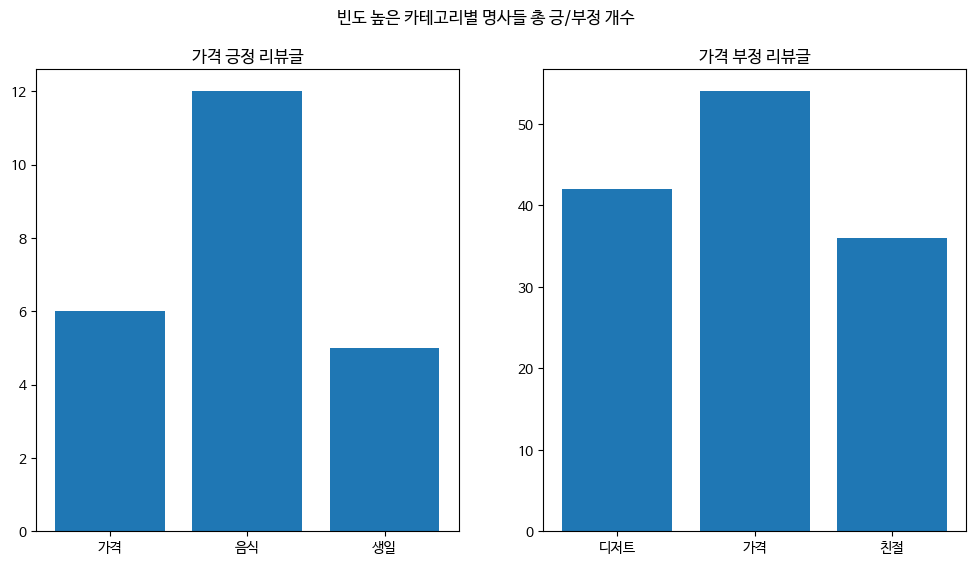

In [168]:
x_positive = np.arange(3)
price_pos_price_emo = price_pos_price_total
price_pos_food_emo = price_pos_food_total
price_pos_birthday_emo = price_pos_birthday_total

x_negative = np.arange(3)
price_neg_dessert_emo = price_neg_dessert_total
price_neg_price_emo = price_neg_price_total
price_neg_kindness_emo = price_neg_kindness_total

fig, ax = plt.subplots(1,2, figsize=(12, 6))

y_p_pos_axis = [price_pos_price_emo,price_pos_food_emo,price_pos_birthday_emo]
x_p_pos_axis = ["가격","음식","생일"]
ax[0].bar(x_positive,y_p_pos_axis)
ax[0].set_xticks(x_positive)
ax[0].set_xticklabels(x_p_pos_axis)
ax[0].set_title("가격 긍정 리뷰글")


y_p_neg_axis = [price_neg_dessert_emo,price_neg_price_emo,price_neg_kindness_emo]
x_p_neg_axis = ["디저트","가격","친절"]
ax[1].bar(x_negative,y_p_neg_axis)
ax[1].set_xticks(x_negative)
ax[1].set_xticklabels(x_p_neg_axis)
ax[1].set_title("가격 부정 리뷰글")

plt.suptitle("빈도 높은 카테고리별 명사들 총 긍/부정 개수")
plt.show()

### 3-7 빈도 높은 명사들의 긍/부정 비율 시각화

- 비율 시각화를 통해 긍/부정 리뷰글에서 명사들이 긍정적인지 부정적인지 확인한다.
- "-"은 비중이 큰 것도 있지만 긍/부정 비율만 비교했을 때 긍/부정 차이가 애매해질 수 있어서 뺐다.
- "만족도" 부정 리뷰글의 가격 긍/부정 비율은 긍정이 없기에 "-"로 대체하였다.
    - 사실상 부정적인 평가만 있다.

In [159]:
# 평가 개수 구하기
satisfy_pos_dessert_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_디저트")
satisfy_pos_food_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_음식")
satisfy_pos_kindness_emo = emotion_eval_counts(satisfy_positive_parse_review, "긍정_친절")

satisfy_neg_food_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_음식")
satisfy_neg_customer_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_사람")
satisfy_neg_price_emo = emotion_eval_counts(satisfy_negative_parse_review, "부정_가격")


# 긍정 + 부정 평가 개수 구하기
satisfy_pos_dessert_total = satisfy_pos_dessert_emo["긍정"] + satisfy_pos_dessert_emo["부정"] #+ satisfy_pos_dessert_emo["-"]
satisfy_pos_food_total = satisfy_pos_food_emo["긍정"] + satisfy_pos_food_emo["부정"] #+ satisfy_pos_food_emo["-"]
satisfy_pos_kindness_total = satisfy_pos_kindness_emo["긍정"] + satisfy_pos_kindness_emo["부정"] #+ satisfy_pos_kindness_emo["-"]

satisfy_neg_food_total = satisfy_neg_food_emo["긍정"] + satisfy_neg_food_emo["부정"] #+ satisfy_neg_food_emo["-"]
satisfy_neg_customer_total = satisfy_neg_customer_emo["긍정"] + satisfy_neg_customer_emo["부정"] #+ satisfy_neg_customer_emo["-"]
satisfy_neg_price_total = satisfy_neg_price_emo["부정"] + satisfy_neg_price_emo["-"]

In [160]:
# 긍/부정 비율 구하기
sp_dessert_positive = percent_emotion(satisfy_pos_dessert_emo["긍정"], satisfy_pos_dessert_total)
sp_dessert_negative = percent_emotion(satisfy_pos_dessert_emo["부정"], satisfy_pos_dessert_total)
# sp_dessert_none = percent_emotion(satisfy_pos_dessert_emo["-"], satisfy_pos_dessert_total)

sp_food_positive = percent_emotion(satisfy_pos_food_emo["긍정"], satisfy_pos_food_total)
sp_food_negative = percent_emotion(satisfy_pos_food_emo["부정"], satisfy_pos_food_total)
# sp_food_none = percent_emotion(satisfy_pos_food_emo["-"], satisfy_pos_food_total)

sp_kindness_positive = percent_emotion(satisfy_pos_kindness_emo["긍정"], satisfy_pos_kindness_total)
sp_kindness_negative = percent_emotion(satisfy_pos_kindness_emo["부정"], satisfy_pos_kindness_total)
# sp_kindness_none = percent_emotion(satisfy_pos_kindness_emo["-"], satisfy_pos_kindness_total)

sn_food_positive = percent_emotion(satisfy_neg_food_emo["긍정"], satisfy_neg_food_total)
sn_food_negative = percent_emotion(satisfy_neg_food_emo["부정"], satisfy_neg_food_total)

sn_customer_positive = percent_emotion(satisfy_neg_customer_emo["긍정"], satisfy_neg_customer_total)
sn_customer_negative = percent_emotion(satisfy_neg_customer_emo["부정"], satisfy_neg_customer_total)

sn_price_none = percent_emotion(satisfy_neg_price_emo["-"], satisfy_neg_price_emo_total)
sn_price_negative = percent_emotion(satisfy_neg_price_emo["부정"], satisfy_neg_price_emo_total)


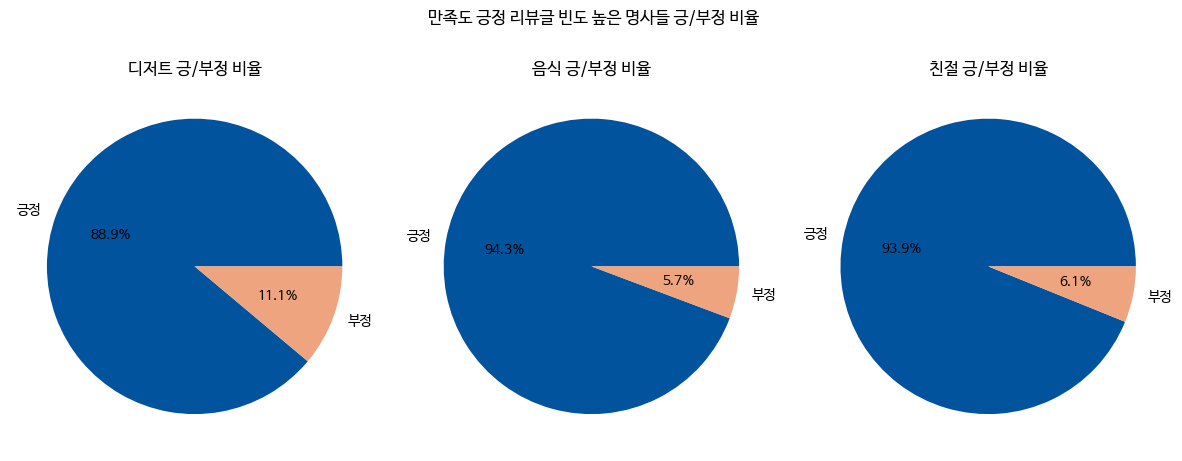

In [153]:
import matplotlib.pyplot as plt


ratio1 = [sp_dessert_positive, sp_dessert_negative]
ratio2 = [sp_food_positive, sp_food_negative]
ratio3 = [sp_kindness_positive, sp_kindness_negative]

labels = ["긍정", "부정"]
colors = ["#00539C", "#EEA47F"]

fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax[0].set_title("디저트 긍/부정 비율")
ax[0].pie(ratio1, labels= labels, autopct='%.1f%%', colors = colors)

ax[1].set_title("음식 긍/부정 비율")
ax[1].pie(ratio2, labels= labels, autopct='%.1f%%', colors = colors)

ax[2].set_title("친절 긍/부정 비율")
ax[2].pie(ratio3, labels= labels, autopct='%.1f%%', colors = colors)

plt.suptitle("만족도 긍정 리뷰글 빈도 높은 명사들 긍/부정 비율")

plt.tight_layout()
plt.show()

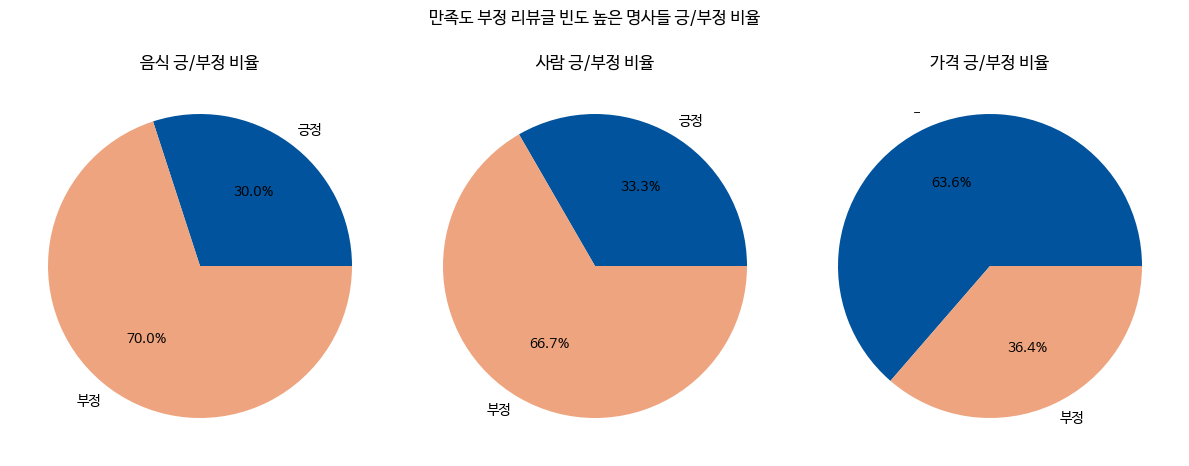

In [162]:
import matplotlib.pyplot as plt


ratio1 = [sn_food_positive, sn_food_negative]
ratio2 = [sn_customer_positive, sn_customer_negative]
ratio3 = [sn_price_none, sn_price_negative]

labels = ["긍정", "부정"]
colors = ["#00539C", "#EEA47F"]

fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax[0].set_title("음식 긍/부정 비율")
ax[0].pie(ratio1, labels= labels, autopct='%.1f%%', colors = colors)

ax[1].set_title("사람 긍/부정 비율")
ax[1].pie(ratio2, labels= labels, autopct='%.1f%%', colors = colors)

labels = ["-", "부정"]
colors = ["#00539C", "#EEA47F"]
ax[2].set_title("가격 긍/부정 비율")
ax[2].pie(ratio3, labels= labels, autopct='%.1f%%', colors = colors)

plt.suptitle("만족도 부정 리뷰글 빈도 높은 명사들 긍/부정 비율")

plt.tight_layout()
plt.show()

In [170]:
# 평가 개수 구하기
price_pos_price_emo = emotion_eval_counts(price_positive_parse_review, "긍정_가격")
price_pos_food_emo = emotion_eval_counts(price_positive_parse_review, "긍정_음식")
price_pos_birthday_emo = emotion_eval_counts(price_positive_parse_review, "긍정_생일")

price_neg_dessert_emo = emotion_eval_counts(price_negative_parse_review, "부정_디저트")
price_neg_price_emo = emotion_eval_counts(price_negative_parse_review, "부정_가격")
price_neg_kindness_emo = emotion_eval_counts(price_negative_parse_review, "부정_친절")


# 긍정 + 부정 평가 개수 구하기
price_pos_dessert_total = price_pos_price_emo["긍정"] + price_pos_price_emo["부정"]
price_pos_food_total = price_pos_food_emo["긍정"] + price_pos_food_emo["부정"]
price_pos_birthday_total = price_pos_birthday_emo["긍정"] + price_pos_birthday_emo["부정"]

price_neg_dessert_total = price_neg_dessert_emo["긍정"] + price_neg_dessert_emo["부정"]
price_neg_price_total = price_neg_price_emo["긍정"] + price_neg_price_emo["부정"]
price_neg_kindness_total = price_neg_kindness_emo["긍정"] + price_neg_kindness_emo["부정"]

In [171]:
# 긍/부정 비율 구하기
ps_price_positive = percent_emotion(price_pos_price_emo["긍정"], price_pos_dessert_total)
ps_price_negative = percent_emotion(price_pos_price_emo["부정"], price_pos_dessert_total)

ps_food_positive = percent_emotion(price_pos_food_emo["긍정"], price_pos_food_total)
ps_food_negative = percent_emotion(price_pos_food_emo["부정"], price_pos_food_total)

ps_birthday_positive = percent_emotion(price_pos_birthday_emo["긍정"], price_pos_birthday_total)
ps_birthday_negative = percent_emotion(price_pos_birthday_emo["부정"], price_pos_birthday_total)


pn_dessert_positive = percent_emotion(price_neg_dessert_emo["긍정"], price_neg_dessert_total)
pn_dessert_negative = percent_emotion(price_neg_dessert_emo["부정"], price_neg_dessert_total)

pn_price_positive = percent_emotion(price_neg_price_emo["긍정"], price_neg_price_total)
pn_price_negative = percent_emotion(price_neg_price_emo["부정"], price_neg_price_total)

pn_kindness_positive = percent_emotion(price_neg_kindness_emo["긍정"], price_neg_kindness_total)
pn_kindness_negative = percent_emotion(price_neg_kindness_emo["부정"], price_neg_kindness_total)

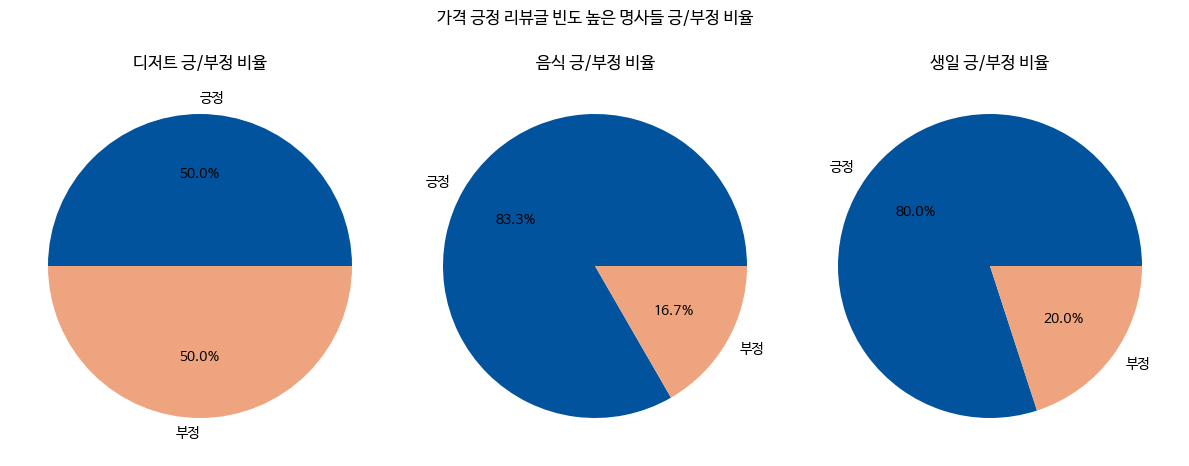

In [172]:
import matplotlib.pyplot as plt


ratio1 = [ps_price_positive, ps_price_negative]
ratio2 = [ps_food_positive, ps_food_negative]
ratio3 = [ps_birthday_positive, ps_birthday_negative]

labels = ["긍정", "부정"]
colors = ["#00539C", "#EEA47F"]

fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax[0].set_title("가격 긍/부정 비율")
ax[0].pie(ratio1, labels= labels, autopct='%.1f%%', colors = colors)

ax[1].set_title("음식 긍/부정 비율")
ax[1].pie(ratio2, labels= labels, autopct='%.1f%%', colors = colors)

ax[2].set_title("생일 긍/부정 비율")
ax[2].pie(ratio3, labels= labels, autopct='%.1f%%', colors = colors)

plt.suptitle("가격 긍정 리뷰글 빈도 높은 명사들 긍/부정 비율")

plt.tight_layout()
plt.show()

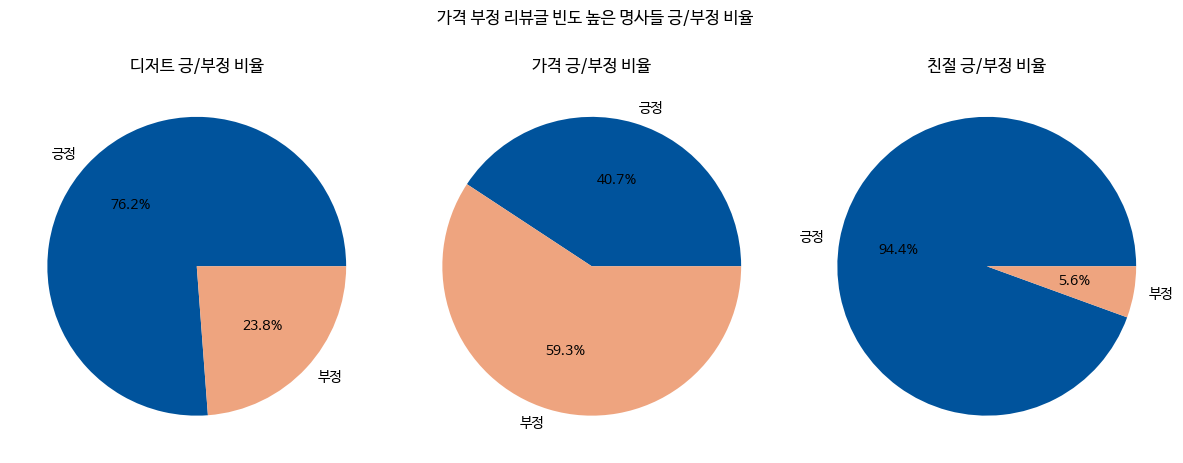

In [173]:
import matplotlib.pyplot as plt


ratio1 = [pn_dessert_positive, pn_dessert_negative]
ratio2 = [pn_price_positive, pn_price_negative]
ratio3 = [pn_kindness_positive, pn_kindness_negative]

labels = ["긍정", "부정"]
colors = ["#00539C", "#EEA47F"]

fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax[0].set_title("디저트 긍/부정 비율")
ax[0].pie(ratio1, labels= labels, autopct='%.1f%%', colors = colors)

ax[1].set_title("가격 긍/부정 비율")
ax[1].pie(ratio2, labels= labels, autopct='%.1f%%', colors = colors)

ax[2].set_title("친절 긍/부정 비율")
ax[2].pie(ratio3, labels= labels, autopct='%.1f%%', colors = colors)

plt.suptitle("가격 부정 리뷰글 빈도 높은 명사들 긍/부정 비율")

plt.tight_layout()
plt.show()

### 3-8 키워드를 리뷰글에서 확인하기

- "가격" 카테고리에서 긍/부정 리뷰글 전부 디저트 키워드가 많은 언급이 되었다.
- 디저트에 부정적인 면이 어떤 것이 있는지 확인해보기 위함이다.
    - 사람들은 가격이 비싸지만 디저트는 맛있다는 류의 평가를 남겼다.
- "디저트" 키워드가 언급된 리뷰글들을 보면 긍정적인 평가가 많다는 것을 알 수 있다.

In [11]:
dessert_review=review[review["Review_Text"].str.contains("디저트")]

In [14]:
dessert_review.tail(10)

,UserID,Review_Text,Date,NumberOfVisit,만족도,맛,서비스,가격
114,vr****,12월엔 꼭 가야 할 일 아니면 비추 일단 연말이라는 이유로 금액이 비싸 짐과 동시...,2022년 12월 21일 수요일,1번째 방문,부정,긍정,긍정,부정
121,조아조아핑,딸기 원 없이 먹고 왔어요 많이 먹자 했는데 막상 또 많이는 못 먹게 되더라고요 디...,2023년 3월 19일 일요일,1번째 방문,부정,긍정,-,부정
128,인천엔젤,대게랑 디저트가 맛있었습니다,2023년 1월 15일 일요일,1번째 방문,긍정,긍정,-,-
134,게으른냐옹,신라는 역시 디저트가 좋아요 디저트와 친절함에 기분이 좋아집니다 꽤 오랜만에 신라에...,2022년 9월 17일 토요일,1번째 방문,긍정,긍정,긍정,-
141,아띠2861,디저트가 정말 훌륭하고 과일 당도도 뛰어나 요 음식은 최곤데 접시가 너무너무 무거워요,2022년 11월 3일 목요일,1번째 방문,긍정,긍정,-,부정
146,행복하자6558,너무 열심히 먹느라 음식 사진 찍는 건 잊고 있었네요 고기 종류 요리가 맛있어요 스...,2022년 7월 9일 토요일,1번째 방문,긍정,긍정,부정,부정
156,G 02,전체적으로 음식에 대한 만족도는 꽤 높습니다 다 만 가격 대비 적정한가에 대해서는 ...,2022년 4월 18일 월요일,1번째 방문,긍정,부정,긍정,부정
163,인헌동당그니,마시어 용 근데 제주보단 덜한 듯 제주는 전복도 있는데 저의 최애 메뉴는 해삼 주스...,2022년 5월 20일 금요일,1번째 방문,긍정,긍정,긍정,-
164,먹깨비깨비16,디저트와 과일 먹으러 가는데 계절에 따라 과일이 차이가 있음 가성비가 좋다고 말하긴...,2022년 4월 9일 토요일,1번째 방문,긍정,긍정,긍정,부정
168,디기디기디기갱갱,가격은 있지만 특별한 날 가기 좋아요 개인적으로 해산물보다는 디저트 육류 순으로 맛...,2022년 10월 10일 월요일,1번째 방문,-,긍정,-,부정


In [12]:
import pandas as pd

dessert_review.to_csv("july_ninteenth_dessert_review.csv", index = False, encoding="utf-8")